# packages


In [375]:
import scipy.stats as stats
import math
from scipy.stats import kruskal
import pandas as pd


from IPython.display import display,HTML

display(HTML("<style>.container {width :95% !important ;}</style>"))


from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


import seaborn as sns
sns.set_context('talk')

from sklearn.metrics import pairwise_distances_argmin_min ,r2_score
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima

# ADP 25회 실기 문제

```{admonition} 1번
**데이터 확인 및 전처리**     
- 1.1 EDA, 이상치 제거 후 F(소비자별 구매빈도), M(소비자별 총 구매액) feature를 새로 생성해서 그 결과값으로 탐색적 분석 실시
- 1.2 F, M feature 기반으로 군집분석 실시
- 1.3 군집 결과의 적합성을 군집 내 응집도, 군집 간 분리도의 개념을 사용해서 서술
- 1.4 적합된 군집 별 특성에 대한 의견과 비즈니스적 판단 제시
- 데이터 설명
    - InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.     
    - StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.     
    - Description: Product (item) name. Nominal.    
    - Quantity: The quantities of each product (item) per transaction. Numeric.     
    - InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.   
    - UnitPrice: Unit price. Numeric, Product price per unit in sterling.    
    - CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.     
    - Country: Country name. Nominal, the name of the country where each customer resides.   
- 출처
    - https://archive.ics.uci.edu/ml/index.phpm
```

송장 번호: 송장 번호입니다. 명목상, 각 트랜잭션에 고유하게 할당된 6자리 정수. 이 코드가 문자 'c'로 시작하면 취소를 나타냅니다.
StockCode: 제품(항목) 코드입니다. 각 개별 제품에 고유하게 할당된 명목상의 5자리 정수입니다.
설명: 제품(항목) 이름입니다. 명사 같은.
수량: 거래당 각 제품(항목)의 수량입니다. 숫자.
InvoiceDate: 송장 날짜 및 시간. 숫자, 각 트랜잭션이 생성된 날짜와 시간입니다.
단가: 단가. 숫자, 단위당 제품 가격(스털링 단위).
고객 ID: 고객 번호입니다. 명목상, 각 고객에게 고유하게 할당된 5자리 정수.
국가: 국가 이름입니다. 명목상, 각 고객이 거주하는 국가의 이름.

In [391]:
import pandas as pd

df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/25/problem1.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,565857,84879,ASSORTED COLOUR BIRD ORNAMENT,16,9/7/2011 14:13,1.69,14911.0,EIRE
1,560452,22432,WATERING CAN PINK BUNNY,6,7/19/2011 9:51,1.95,12682.0,France
2,578509,22492,MINI PAINT SET VINTAGE,36,11/24/2011 13:17,0.65,12705.0,Germany
3,579345,22728,ALARM CLOCK BAKELIKE PINK,8,11/29/2011 11:46,3.75,12727.0,France
4,564039,21731,RED TOADSTOOL LED NIGHT LIGHT,12,8/22/2011 12:40,1.65,12645.0,Germany


## 1.1 EDA, 이상치 제거 후 F(소비자별 구매빈도), M(소비자별 총 구매액) feature를 새로 생성해서 그 결과값으로 탐색적 분석 실시

InvoiceDate,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
count,2115,2948,2017,3093,1499,2932,3219,2750,3583,4333,5517,5542,1461



UnitPrice값이 0인 경우가 존재한다. 제품금액이 0 원인 경우는 이상치로 보고 제거한다.
데이터의 경우 2010년 12월 부터 2011년 12월까지 13개월동안의 데이터이다. 전체기간을 2구간으로 나누어 각각에 대해 고객별 F와 M관련 변수들을 추출한다.
F의 경우 두 구간의 기간별 총 구매 빈도와 총 취소빈도를 만든다. 
M의 경우 두 구간의 기간별 평균 구매량과 평균 구매금액에 대한 데이터를 구한다.
최종적인 데이터는 아래와 같다.



,F_price_order_dum_0,F_price_order_dum_1,F_price_cancel_dum_0,F_price_cancel_dum_1,M_mean_quantity_dum_0,M_mean_quantity_dum_1,M_mean_price_dum_0,M_mean_price_dum_1
CustomerID,,,,,,,,
12348.0,28.0,3.0,0.0,0.0,75.857143,72.333333,53.115714,103.333333
12349.0,0.0,73.0,0.0,0.0,0.000000,8.643836,0.000000,24.076027
12350.0,17.0,0.0,0.0,0.0,11.588235,0.000000,19.670588,0.000000
12352.0,38.0,47.0,10.0,0.0,6.684211,6.000000,41.100263,20.090000
12354.0,58.0,0.0,0.0,0.0,9.137931,0.000000,18.610345,0.000000



생성된 피쳐 데이터의 boxplot을 찍어보면 첫번째와 두번째 컬럼에서 이상치들이 보인다. 95% 백분위이상인 데이터를 걸러낸다. 



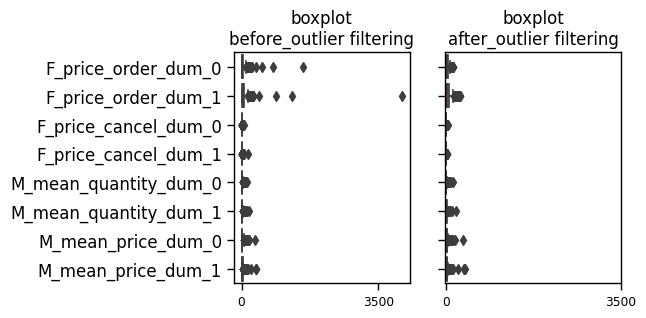

In [392]:
#이상치 제거
df = df[df.UnitPrice !=0].reset_index(drop=True)
df['totalPrice'] = df['Quantity'] *df['UnitPrice']

#날짜 변환
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
display(df.InvoiceDate.astype('str').str.split(' ').str[0].str[:-3].value_counts().sort_index().to_frame().T)

#6,7개월로 기간 분리
date_map = {
    '2010-12':0,
    '2011-01':0,
    '2011-02':0,
    '2011-03':0,
    '2011-04':0,
    '2011-05':0,
    '2011-06':1,
    '2011-07':1,
    '2011-08':1,
    '2011-09':1,
    '2011-10':1,
    '2011-11':1,
    '2011-12':1,
}

df['month_dum'] = df.InvoiceDate.astype('str').str.split(' ').str[0].str[:-3].map(date_map)


# 취소여부 
notcancel = df[df.InvoiceNo.str[0] != 'C'] .reset_index(drop=True)
cancel =df[df.InvoiceNo.str[0] == 'C'].reset_index(drop=True)


f = pd.DataFrame()
m = pd.DataFrame()

# 기간에 따른 구매 내역
f_price = notcancel.groupby(['CustomerID','month_dum'])['UnitPrice'].size().unstack()
f_price.columns = ['F_price_order_dum_' +str(i) for i in range(2)]

cancel_price = cancel.groupby(['CustomerID','month_dum'])['UnitPrice'].size().unstack().fillna(0)
cancel_price.columns = ['F_price_cancel_dum_' +str(i) for i in range(2)]

m_mean_quentity = notcancel.groupby(['CustomerID','month_dum'])['Quantity'].mean().unstack().fillna(0)
m_mean_quentity.columns = ['M_mean_quantity_dum_' +str(i) for i in range(2)]

m_mean_price = notcancel.groupby(['CustomerID','month_dum'])['totalPrice'].mean().unstack().fillna(0)
m_mean_price.columns = ['M_mean_price_dum_' +str(i) for i in range(2)]


t = pd.concat([f_price,cancel_price,m_mean_quentity,m_mean_price],axis=1).fillna(0)

print('''
UnitPrice값이 0인 경우가 존재한다. 제품금액이 0 원인 경우는 이상치로 보고 제거한다.
데이터의 경우 2010년 12월 부터 2011년 12월까지 13개월동안의 데이터이다. 전체기간을 2구간으로 나누어 각각에 대해 고객별 F와 M관련 변수들을 추출한다.
F의 경우 두 구간의 기간별 총 구매 빈도와 총 취소빈도를 만든다. 
M의 경우 두 구간의 기간별 평균 구매량과 평균 구매금액에 대한 데이터를 구한다.
최종적인 데이터는 아래와 같다.
''')

display(t.head())


t_filter = t[(t.F_price_order_dum_0 <= t.F_price_order_dum_0.quantile(0.95))]

fig,ax = plt.subplots(1,2,figsize=(5,3), sharey=True)
sns.boxplot(t, orient='h',ax=ax[0])
sns.boxplot(t_filter, orient='h',ax=ax[1])
ax[0].tick_params(axis='y', labelsize=12) 
ax[0].set_title('boxplot\nbefore_outlier filtering',fontsize=12)
ax[1].set_title('boxplot\nafter_outlier filtering',fontsize=12)
ax[1].set_xticks([0,3500],[0,3500])
ax[0].set_xticks([0,3500],[0,3500])

print('''
생성된 피쳐 데이터의 boxplot을 찍어보면 첫번째와 두번째 컬럼에서 이상치들이 보인다. 95% 백분위이상인 데이터를 걸러낸다. 
''')

## F, M feature 기반으로 군집분석 실시

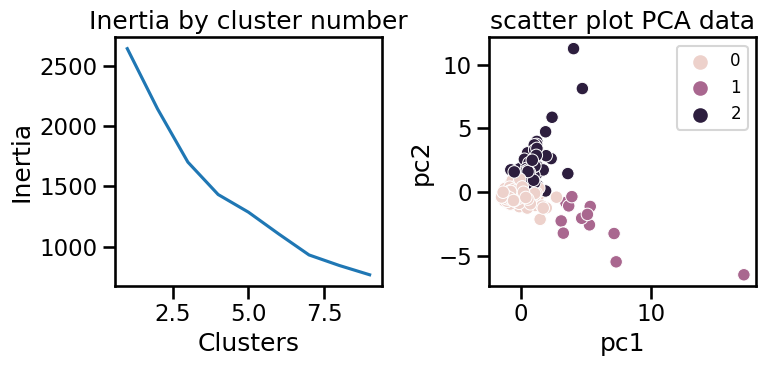

데이터 정규화를 한 후 클러스터 갯수에 따른 inertia를 추출하고 엘보우 기법을 통해 최적의 클러스터를 3개로 결정한다.
두번째 그래프는 정규화한 데이터를 pca를 통해 2개 주성분으로 차원축소한 후 클러스터링 레이블링을 시각화한 모습이다.


In [396]:
sns.set_context('talk')
ss = StandardScaler()
scaled_df = ss.fit_transform(t_filter)

km = KMeans(random_state =1)
km.fit(scaled_df)
km_pred = km.fit_predict(scaled_df)


fig,ax = plt.subplots(1,2,figsize=(8,4))

lst = []
for k in range(1, 10): 
    kmeans = KMeans(n_clusters=k,random_state=1)
    kmeans.fit(scaled_df)
    lst.append(kmeans.inertia_) 

ax[0].plot(range(1, 10), lst)
ax[0].set_xlabel('Clusters')
ax[0].set_ylabel('Inertia')
ax[0].set_title('Inertia by cluster number')



n_cluter =3
km = KMeans(n_clusters=n_cluter,random_state=1)
km_pred = km.fit_predict(scaled_df)


pca = PCA(n_components=2)
pca_df = pd.DataFrame(pca.fit_transform(scaled_df),columns =['pc1','pc2'])
pca_df['cluster_label'] = km_pred
sns.scatterplot(data =pca_df,x = 'pc1',y= 'pc2',hue='cluster_label',ax=ax[1])

fig.tight_layout()
ax[1].set_title('scatter plot PCA data')
ax[1].legend(fontsize=12)
plt.show()

print('데이터 정규화를 한 후 클러스터 갯수에 따른 inertia를 추출하고 엘보우 기법을 통해 최적의 클러스터를 3개로 결정한다.')
print('두번째 그래프는 정규화한 데이터를 pca를 통해 2개 주성분으로 차원축소한 후 클러스터링 레이블링을 시각화한 모습이다.')


## 군집 결과의 적합성을 군집 내 응집도, 군집 간 분리도의 개념을 사용해서 서술

In [273]:
inertia = km.inertia_
d = pairwise_distances_argmin_min(km.cluster_centers_, scaled_df)[1]
sep = sum(d) / len(d)

print(f'군집결과의 응집도는 {round(inertia,3)},분리도는 {round(sep,3)}값을 가진다. ')

군집결과의 응집도는 1701.515,분리도는 1.238값을 가진다. 


## 적합된 군집 별 특성에 대한 의견과 비즈니스적 판단 제시

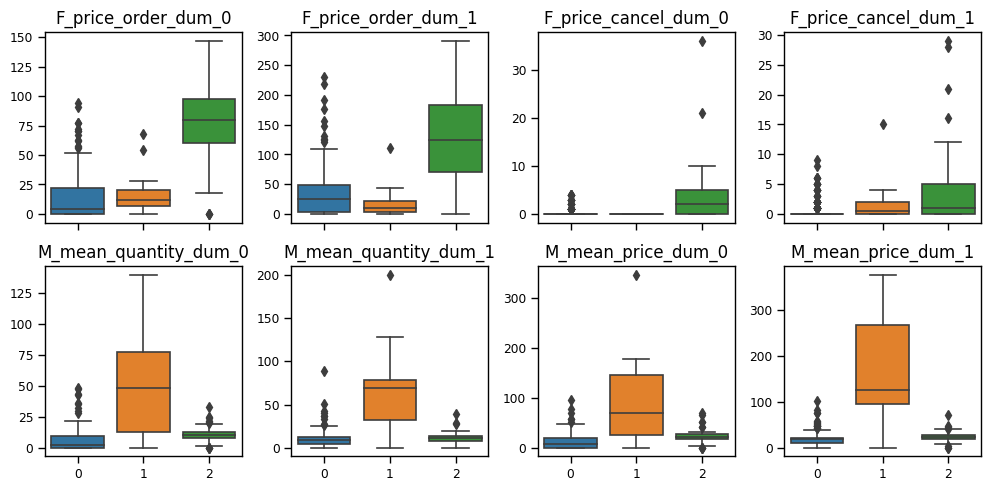

3개 군집의 데이터 분포를 나타낸 것이다. 2번 군집의 경우 F관련 변수들이 다른 두 군집에 비해 상대적으로 높게 나타남을 알 수 있다.
1번군집의 경우 M관련 변수들이 다른 두 굽지에 비행 상대적으로 높으며 2번군집의 경우 그 중간의 경향을 보인다.
이러한 특성을 확인하여 비지니스 전략을 세울수 있다. 예를들어 2번군집의 경우 구매가 다른 구집에 비해 잦은 구매를 하므로
포장 관련 할인 혜택등을 통해 고객 만족을 증가시키는 등의 전략을 세울수 있다.


In [293]:
t_filter['label'] = km_pred
sns.set_context('paper')
fig,axes = plt.subplots(2,4,figsize=(10,5),sharex=True)
for i,ax in enumerate(axes.flat):
    
    target_column =t_filter.columns[i]
    target_df = t_filter[[target_column,'label']]
    
    sns.boxplot(data =target_df , x = 'label',y = target_column,ax = ax)
    
    ax.set_ylabel('')
    ax.set_title(target_column,fontsize=12)
    ax.set_xlabel('')
    
fig.tight_layout()
plt.show()

print('3개 군집의 데이터 분포를 나타낸 것이다. 2번 군집의 경우 F관련 변수들이 다른 두 군집에 비해 상대적으로 높게 나타남을 알 수 있다.')
print('1번군집의 경우 M관련 변수들이 다른 두 굽지에 비행 상대적으로 높으며 2번군집의 경우 그 중간의 경향을 보인다.')
print('이러한 특성을 확인하여 비지니스 전략을 세울수 있다. 예를들어 2번군집의 경우 구매가 다른 구집에 비해 잦은 구매를 하므로')
print('포장 관련 할인 혜택등을 통해 고객 만족을 증가시키는 등의 전략을 세울수 있다.')

```{admonition} 2번
**시계열분석**     
- 2.1 EDA와 시각화를 진행하라
- 2.2 결측치 처리와 해당 결측치 처리 방식에 대한 논리적 근거를 제시하라
- 2.3 계절성을 반영한 시계열 모델을 제시하고 정확도 측면에서 모델 성능 평가 할 것
- 2.4 분석 결과 활용 가능 여부에 대한 분석 전문가로서의 제안

```

In [352]:
import pandas as pd

df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/25/problem2.csv',index_col = 0)
df.head()

,counts
0,544.3
1,603.1
2,NaN
3,533.4
4,619.5


## 2.1 EDA와 시각화를 진행하라

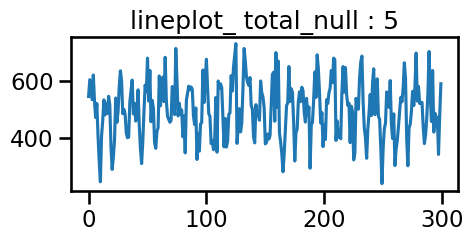

,count,mean,std,min,25%,50%,75%,max
counts,295.0,498.678305,97.60392,239.4,432.6,499.8,565.55,729.2


전체 결측치 숫자는 5개이다.


In [353]:
n= df.isnull().sum().values[0]
fig,ax = plt.subplots(1,figsize=(5,2))
sns.lineplot(df,ax=ax,legend=False)
plt.title(f'lineplot_ total_null : {n}')
plt.show()
display(df.describe().T)
print('전체 결측치 숫자는 5개이다.')

df['pseudo_month'] =pd.date_range(start='2023-01-01',end ='2100-01-01', freq='MS')[:300]



## 2.2 결측치 처리와 해당 결측치 처리 방식에 대한 논리적 근거를 제시하라

In [388]:
df['counts'] = df['counts'].fillna((df['counts'].shift() + df['counts'].shift(-1)) / 2)


print('EDA상에서 주기적인 패턴이 보이므로 결측치는 직전값과 이후값의 평균으로 채운다')

EDA상에서 주기적인 패턴이 보이므로 결측치는 직전값과 이후값의 평균으로 채운다


## 2.3 계절성을 반영한 시계열 모델을 제시하고 정확도 측면에서 모델 성능 평가 할 것

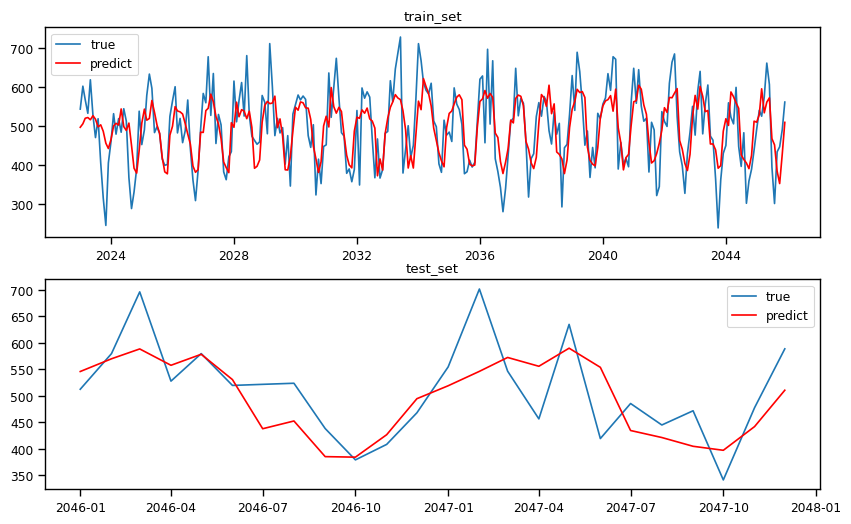

계절성을 반영한 SARIMA모델을 통해 학습한다. 학습데이터는 276개로하고 평가는 마지막 24개의 데이터로 한다.
평가지표는 r2값으로 한다. 그결과는 0.44722599849053와 같다.


In [387]:
train = df.iloc[:276]
test = df.iloc[-24:]

# SARIMA 모델 생성
model = auto_arima(train['counts'], seasonal=True, m=12, stepwise=True)
predictions = model.predict_in_sample()

test_predictions = model.predict(n_periods=24)
r2_scores = r2_score(test['counts'], test_predictions)

sns.set_context('paper')
fig,ax= plt.subplots(2,1,figsize=(10,6))
ax[0].plot(train.pseudo_month, train['counts'], label='true')
ax[0].plot(train.pseudo_month, predictions, label='predict', color='red')
ax[0].set_title('train_set')
ax[1].set_title('test_set')
ax[1].plot(test.pseudo_month, test['counts'], label='true')
ax[1].plot(test.pseudo_month, test_predictions, label='predict', color='red')

ax[0].legend()
ax[1].legend()
plt.show()



print('계절성을 반영한 SARIMA모델을 통해 학습한다. 학습데이터는 276개로하고 평가는 마지막 24개의 데이터로 한다.')
print(f'평가지표는 r2값으로 한다. 그결과는 {r2_scores}와 같다.')

## 2.4 분석 결과 활용 가능 여부에 대한 분석 전문가로서의 제안

모델 최적화 과정을 거진 후 12개월 단위의 예측을 통해 미리 대비 가능~~

```{admonition} 3번
**통계문제**     
```

```{admonition} 3-1번
**서울에서 영동까지 100km/h로 가고 영동에서 서울까지 80km/로 돌아왔을 때, 평균 속도는?**
```

In [5]:
# distance_seoul_to_youngdong =s    
# time_seoul_to_youngdong = s /100    
# time_seoul_to_youngdong = s /80    
# average_velocity = 2*s / (s/100 + s/80)

average_velocity = 2/(1/100 +1/80)
print('답안\n서울과 영동까지 거리를 미지수로 놓고 평균속도 구하는 공식 (총거리 / 총시간)을 통해 계산하면')
print(f'평균 속도는 {average_velocity}가 나온다')

답안
서울과 영동까지 거리를 미지수로 놓고 평균속도 구하는 공식 (총거리 / 총시간)을 통해 계산하면
평균 속도는 88.88888888888889가 나온다


```{admonition} 3-2번
**연매출이 3000, 4000, 5000이었다면 연평균 몇배가 증가한 것인가?**
```

In [6]:
geometric_mean = (3000*4000*5000)**(1/3)
ratio = (geometric_mean - 3000)/3000


print(f'답안\n기하평균을 구하고 첫해 매출과 비교하여 비율을 구한다. 결과적으로 {ratio}배 증가한 것을 확인 할 수 있다.')

답안
기하평균을 구하고 첫해 매출과 비교하여 비율을 구한다. 결과적으로 0.3049558803896205배 증가한 것을 확인 할 수 있다.


```{admonition} 3-3번
**남성, 여성의 등산, 수영에 대한 취미 선호도 빈도표(2x2)를 보고, 남성 중에서 등산을 좋아할 확률을 구하시오**
```

![image](https://github.com/Datamanim/datarepo/blob/main/adp/25/problem3_3.png?raw=true)

In [294]:
### 베이즈?

```{admonition} 3-4번
**표본 10개의 분산이 90일 때 신뢰도 95%로 모분산의 신뢰구간을 추정**
```

In [14]:
sample_variance = 90  # 표본 분산
sample_size = 10  # 표본 크기
confidence_level = 0.95  # 신뢰도

df = sample_size - 1
alpha = 1 - confidence_level
chi2_lower = stats.chi2.ppf(alpha / 2, df)
chi2_upper = stats.chi2.ppf(1 - alpha / 2, df)

# 모분산의 신뢰구간 계산
confidence_interval_lower = (df * sample_variance) / chi2_upper
confidence_interval_upper = (df * sample_variance) / chi2_lower
confidence_interval_lower ,confidence_interval_upper

(42.58055444790953, 299.95672846672363)

```{admonition} 4번
**4번 임상 대상 20명에 대해 혈압약 투약 이전과 이후의 차이가 24, 표준편차 9  신뢰구간 95%, 차이가 존재하는지 확인하려한다**     
- 4.1 귀무가설과 연구가설을 제시하시오
- 4.2 검정 후 귀무가설 기각 여부 제시

```

In [16]:
n = 20
x_bar = 24
s = 9
alpha = 0.05

t_statistic = (x_bar - 0) / (s / (n ** 0.5))
critical_value = stats.t.ppf(1 - alpha/2, df=n - 1)
p_value = 2 * (1 - stats.t.cdf(abs(t_statistic), df=n - 1))

print('답안\n귀무가설은 "혈압약 투약 이전과 이후의 차이는 없다" 이고\n대립가설은 "혈압약 투약 이전과 이후의 차이는 있다"')
print(f'p-value값은 {p_value} 이고 유의 수준 0.05하에서 귀무가설을 기각한다. 혈압약 투약 이전과 이후의 차이는 유의하다.')

답안
귀무가설은 "혈압약 투약 이전과 이후의 차이는 없다" 이고
대립가설은 "혈압약 투약 이전과 이후의 차이는 있다"
p-value값은 2.8772539906185557e-10 이고 유의 수준 0.05하에서 귀무가설을 기각한다. 혈압약 투약 이전과 이후의 차이는 유의하다.


```{admonition} 5번
**공장 X,Y,Z의 평균 출하 소요시간을 여러 일자에 거쳐 측정한 데이터이다. 각 공장의 중위수의 차이가 존재하는지 확인하려 한다**     
- 5.1 귀무가설과 연구가설을 제시하시오
- 5.2 검정 후 귀무가설 기각 여부 제시

```

In [21]:
import pandas as pd
df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/25/problem5.csv',encoding='cp949')
df.head()

,출하 소요시간,공장명,공장별 출하 소요시간 순위
0,71,Z,11
1,75,X,14
2,71,X,12
3,53,Z,1
4,50,X,1


In [33]:

h_statistic, p_value = stats.kruskal(df.query("공장명 =='X'")['출하 소요시간']\
                                     , df.query("공장명 =='Y'")['출하 소요시간']\
                                     , df.query("공장명 =='Z'")['출하 소요시간'])

# 검정 결과 출력
print("H 통계량:", h_statistic)
print("p-값:", p_value)

H 통계량: 0.7217886080379153
p-값: 0.6970526702392181


```{admonition} 6번
**1개년 50억원, 2개년 60억원, 3개년 70억원의 예산을 가지고 NPV(순현재가치)가 가장 높아지는 안을 제시하시오**     

```

![image](https://github.com/Datamanim/datarepo/blob/main/adp/25/problem6.png?raw=true)